# Plot the network output versus all possible weight combos in a network where the sign of a gradient might flip

Minimal example network
![setup.png](../setup.png)

In [1]:
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm


import utils.sign_change_net as scn
import utils.plotting as plotting

from jax import config

config.update("jax_enable_x64", True)

2024-05-03 10:22:16.396701: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
device_idx = 0
jax.config.update("jax_default_device", jax.devices()[device_idx])

### Define input and weights

In [3]:
x = jnp.array(1)

# weights
w = jnp.array(1)
v1 = jnp.array(0.05)
v2 = jnp.array(0.1)
u1 = jnp.array(1)
u2 = jnp.array(-1)


In [4]:
# Define betas and surrogate betas
beta_sgs = [2, 4, 20]
beta = beta_sgs[-1]

beta_sgs_w = [15, 30, 100]
beta_w = beta_sgs_w[-1]


In [5]:
# define axes
u1_ax = jnp.linspace(-2, 2, 1001)
u2_ax = jnp.linspace(-2, 2, 1011)

v1_ax = jnp.linspace(-2, 2, 1021)
v2_ax = jnp.linspace(-2, 2, 1031)

w_ax = jnp.linspace(-0.2, 0.2, 10001)


In [6]:
grads = {}
grad_scale = 50
head_width = 0.2

# define point to get gradients
gw = jnp.array(-0.188)
gv1 = jnp.array(1.7)
gv2 = jnp.array(-1.3)
gu1 = jnp.array(-0.1)
gu2 = jnp.array(1)


In [7]:
# define plotting parameters

cmap = "Greys_r"
arrow = "#ebb400"
color = "#008ca5"
levels = 20

preamble = "Plots/"

100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


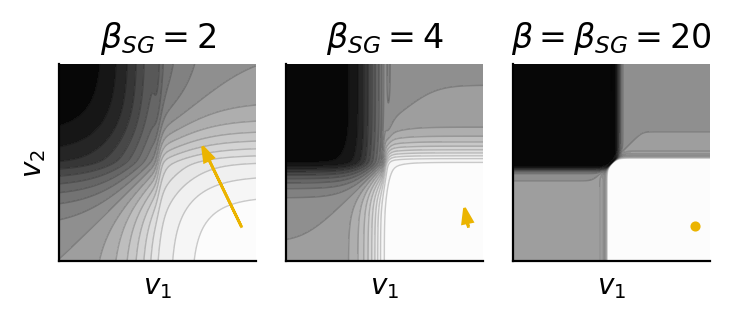

In [8]:
fig, ax = plt.subplots(
    1,
    len(beta_sgs),
    figsize=(1.25 * len(beta_sgs), 3),
    dpi=200,
    sharex=True,
    sharey=True,
    subplot_kw={"adjustable": "box", "aspect": 1},
)

for i, beta_sg in enumerate(tqdm(beta_sgs)):
    y = scn.net_v(w, v1_ax, v2_ax, u1, u2, x, beta)

    grads = scn.grad_value(w, gv1, gv2, u1, u2, x, beta, beta_sg)
    grad = jnp.array([grads[1], grads[2]]) * grad_scale
    # grad = grad/jnp.linalg.norm(grad) * grad_scale

    ref_idx = 0
    ref_i_grad, ref_grad = scn.get_gradients_over_v1(
        w, v1_ax, v2_ax[ref_idx], u1, u2, x, beta, beta_sg, y[ref_idx]
    )
    i_grad_1, grad_1 = scn.get_grads_over_v2_for_all_v1(
        w, v1_ax, v2_ax, u1, u2, x, beta, beta_sg, ref_i_grad
    )
    i_grad_1_norm = (i_grad_1 - jnp.min(i_grad_1)) / (
        jnp.max(i_grad_1) - jnp.min(i_grad_1)
    )
    plotting.contour(
        ax[i],
        v1_ax,
        v2_ax,
        jnp.transpose(i_grad_1_norm),
        levels=levels,
        cmap=cmap,
        color="black",
        alpha=0.2,
    )
    if i == len(beta_sgs) - 1:
        ax[i].scatter(gv1, gv2, color=arrow, s=7)
        ax[i].set_title(r"$\beta = \beta_{SG} = $" + r"${}$".format(beta_sg))
    else:
        ax[i].arrow(
            gv1, gv2, *(grad * -1), color=arrow, head_width=head_width, zorder=10
        )
        ax[i].set_title(r"$\beta_{SG} = $" + r"${}$".format(beta_sg))

    ax[i].set_xlabel(r"$v_1$")

ax[0].set_ylabel(r"$v_2$")
ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
sns.despine()
plt.savefig(preamble + "SGs_over_v_1.svg")
plt.show()

100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


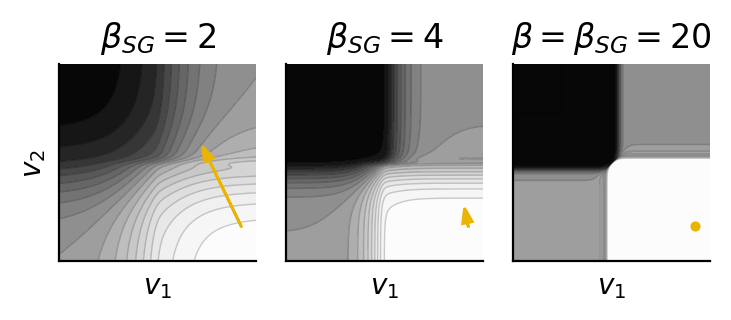

In [9]:
fig, ax = plt.subplots(
    1,
    len(beta_sgs),
    figsize=(1.25 * len(beta_sgs), 3),
    dpi=200,
    sharex=True,
    sharey=True,
    subplot_kw={"adjustable": "box", "aspect": 1},
)

for i, beta_sg in enumerate(tqdm(beta_sgs)):
    y = scn.net_v(w, v1_ax, v2_ax, u1, u2, x, beta)
    grads = scn.grad_value(w, gv1, gv2, u1, u2, x, beta, beta_sg)
    grad = jnp.array([grads[1], grads[2]]) * grad_scale

    ref_idx = 0
    ref_i_grad, ref_grad = scn.get_gradients_over_v2(
        w, v1_ax[ref_idx], v2_ax, u1, u2, x, beta, beta_sg, jnp.transpose(y)[ref_idx]
    )
    i_grad_2, grad_2 = scn.get_grads_over_v1_for_all_v2(
        w, v1_ax, v2_ax, u1, u2, x, beta, beta_sg, ref_i_grad
    )
    i_grad_2_norm = (i_grad_2 - jnp.min(i_grad_2)) / (
        jnp.max(i_grad_2) - jnp.min(i_grad_2)
    )
    plotting.contour(
        ax[i],
        v1_ax,
        v2_ax,
        i_grad_2_norm,
        levels=levels,
        cmap=cmap,
        color="black",
        alpha=0.2,
    )

    if i == len(beta_sgs) - 1:
        ax[i].scatter(gv1, gv2, color=arrow, s=7)
        ax[i].set_title(r"$\beta = \beta_{SG} = $" + r"${}$".format(beta_sg))
    else:
        ax[i].arrow(
            gv1, gv2, *(grad * -1), color=arrow, head_width=head_width, zorder=10
        )
        ax[i].set_title(r"$\beta_{SG} = $" + r"${}$".format(beta_sg))


    ax[i].set_xlabel(r"$v_1$")

ax[0].set_ylabel(r"$v_2$")
ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
sns.despine()
plt.savefig(preamble + "SGs_over_v_2.svg")
plt.show()

# Vary over parameter $w$

In [10]:
def normalize(x):
    return (x - jnp.min(x)) / (jnp.max(x) - jnp.min(x))


def scale(x, scaling=1, offset=1):
    scaled = x * (scaling / (x[0] - x[-1]))
    scaled += offset - scaled[0]
    return scaled

def minmax_scaling(x):
    return x / (jnp.max(x) - jnp.min(x))

100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


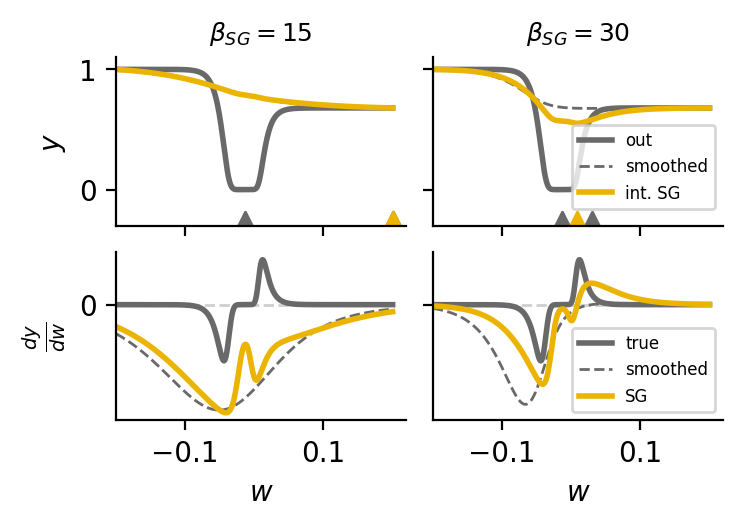

In [11]:
fac = 1.2
fig, ax = plt.subplots(
    2,
    len(beta_sgs_w)-1,
    dpi=200,
    sharex=True,
    sharey="row",
    figsize=(len(beta_sgs_w)*fac, 2.1*fac),
    constrained_layout=True,
)

for i, beta_sg in enumerate(tqdm(beta_sgs_w[:-1])):
    # plot network output
    y = scn.net_w(w_ax, v1, v2, u1, u2, x, beta_w)
    norm_y = (y - jnp.min(y)) / (jnp.max(y) - jnp.min(y))
    ax[0][i].plot(w_ax, norm_y, color="dimgrey", lw=2, alpha=1, label="out", zorder=-2)

    # indicate minimum location
    idx = jnp.argmin(norm_y)
    ax[0][i].scatter(w_ax[idx], -0.25, color="dimgrey", lw=1, marker="^")

    out_diff = norm_y[0] - norm_y[-1]

    # plot true gradients
    int_grad_true, gradient_true = scn.get_gradients_over_w(
        w_ax, v1, v2, u1, u2, x, beta_w, beta_w, y[0]
    )

    scaled_grad_true = minmax_scaling(jnp.array(gradient_true))
    ax[1][i].plot(
        w_ax, scaled_grad_true, color="dimgrey", lw=2, alpha=1, label=r"true"
    )

    ####################################################################################################################
    # USING ONLY BETA_SG
    ####################################################################################################################

    y_sigm = scn.net_w(w_ax, v1, v2, u1, u2, x, beta_sg)
    scaled_y_sigm = scale(y_sigm, scaling=out_diff, offset=1)
    ax[0][i].plot(
        w_ax,
        scaled_y_sigm,
        color="dimgrey",
        lw=1,
        alpha=1,
        ls="--",
        label="smoothed",
        zorder=-1,
    )

    idx = jnp.argmin(scaled_y_sigm)
    ax[0][i].scatter(w_ax[idx], -0.25, color="dimgrey", lw=1, marker="^", zorder=-1)

    int_grad_true_sigm, gradient_true_sigm = scn.get_gradients_over_w(
        w_ax, v1, v2, u1, u2, x, beta_sg, beta_sg, y[0]
    )

    norm_grad_true_sigm = minmax_scaling(jnp.array(gradient_true_sigm))
    ax[1][i].plot(
        w_ax,
        norm_grad_true_sigm,
        color="dimgrey",
        lw=1,
        alpha=1,
        ls="--",
        label="smoothed",
        zorder=-1,
    )

    ####################################################################################################################
    # SURROGATE GRADIENTS
    ####################################################################################################################

    # plot integrated surrogate gradients
    int_grad, gradient = scn.get_gradients_over_w(
        w_ax, v1, v2, u1, u2, x, beta_w, beta_sg, y[0]
    )

    scaled_int_grad = scale(jnp.array(int_grad), scaling=out_diff, offset=1)
    ax[0][i].plot(w_ax, scaled_int_grad, color=arrow, lw=2, alpha=1, label="int. SG")

    # indicate minimum location
    idx = jnp.argmin(scaled_int_grad)
    ax[0][i].scatter(w_ax[idx], -0.25, color=arrow, lw=1, marker="^")

    norm_grad = minmax_scaling(jnp.array(gradient))
    ax[1][i].plot(w_ax, norm_grad, color=arrow, lw=2, alpha=1, label="SG")

    ax[1][i].hlines(
        0, w_ax[0], w_ax[-1], color="silver", lw=1, linestyle="--", alpha=0.75, zorder=-3
    )

    ax[0][i].set_title(r"$\beta_{SG} =$" + r"{}".format(beta_sg), fontsize=9)
    ax[1][i].set_xlabel(r"$w$")


ax[0][0].set_ylabel(r"$y$")
ax[1][0].set_ylabel(r"$\frac{dy}{dw}$")
ax[0][-1].legend(fontsize=6, loc="lower left", bbox_to_anchor=(0.45, 0.05))
ax[1][-1].legend(fontsize=6, loc="lower right")

ax[0][0].set_yticks([0, 1])
ax[1][0].set_yticks([0])
ax[1][0].set_xticks([-0.1, 0.1])

ax[1][0].set_xlim([-0.2, 0.22])
ax[0][0].set_ylim([-0.3, 1.1])


sns.despine()
plt.savefig(preamble + "sg_vs_true_g.pdf")
plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 11.90it/s]


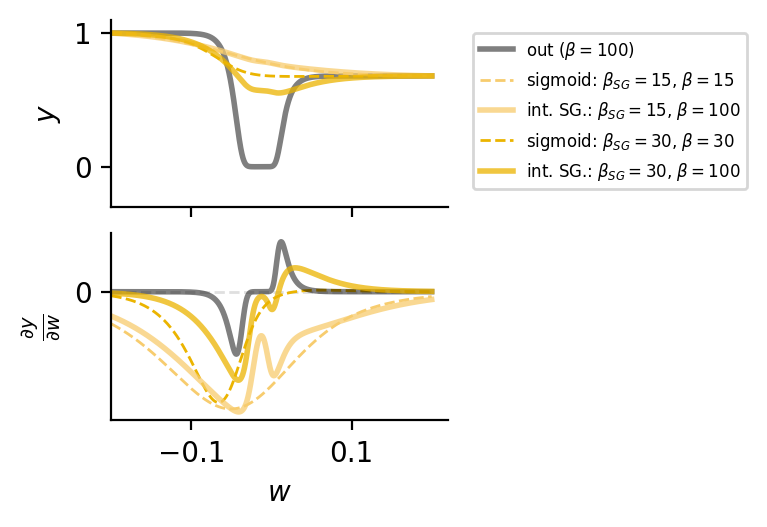

In [12]:
fac = 1.2
fig, ax = plt.subplots(
    2,
    1,
    dpi=200,
    sharex=True,
    sharey="row",
    figsize=(3.1 * fac, 2.1 * fac),
    constrained_layout=True,
)

yellows = ["#f7cc6e", "#EBB400", "#b28912"]

# plot network output
y = scn.net_w(w_ax, v1, v2, u1, u2, x, beta_w)
norm_y = (y - jnp.min(y)) / (jnp.max(y) - jnp.min(y))
ax[0].plot(w_ax, norm_y, color="black", lw=2, alpha=0.5, label=r"out ($\beta = $"+str(beta_w)+")", zorder=-2)

# indicate minimum location
idx = jnp.argmin(norm_y)
# ax[0].scatter(w_ax[idx], -0.25, color="dimgrey", lw=1, marker="^")

out_diff = norm_y[0] - norm_y[-1]

# plot true gradients
int_grad_true, gradient_true = scn.get_gradients_over_w(
    w_ax, v1, v2, u1, u2, x, beta_w, beta_w, y[0]
)

scaled_grad_true = minmax_scaling(jnp.array(gradient_true))
ax[1].plot(w_ax, scaled_grad_true, color="black", lw=2, alpha=0.5, label=r"true")


for i, beta_sg in enumerate(tqdm(beta_sgs_w[:-1])):

    ####################################################################################################################
    # USING ONLY BETA_SG
    ####################################################################################################################

    y_sigm = scn.net_w(w_ax, v1, v2, u1, u2, x, beta_sg)
    scaled_y_sigm = scale(y_sigm, scaling=out_diff, offset=1)
    ax[0].plot(
        w_ax,
        scaled_y_sigm,
        color=yellows[i],
        lw=1,
        alpha=1,
        label=r"sigmoid: $\beta_{SG} = $" + str(beta_sg) + r", $\beta = $" + str(beta_sg),
        ls="--",
        zorder=-1,
    )

    idx = jnp.argmin(scaled_y_sigm)
    # ax[0].scatter(w_ax[idx], -0.25, color="dimgrey", lw=1, marker="^", zorder=-1)

    int_grad_true_sigm, gradient_true_sigm = scn.get_gradients_over_w(
        w_ax, v1, v2, u1, u2, x, beta_sg, beta_sg, y[0]
    )

    norm_grad_true_sigm = minmax_scaling(jnp.array(gradient_true_sigm))
    ax[1].plot(
        w_ax,
        norm_grad_true_sigm,
        color=yellows[i],
        lw=1,
        alpha=1,
        ls="--",
        label="smoothed",
        zorder=-1,
    )

    ####################################################################################################################
    # SURROGATE GRADIENTS
    ####################################################################################################################

    # plot integrated surrogate gradients
    int_grad, gradient = scn.get_gradients_over_w(
        w_ax, v1, v2, u1, u2, x, beta_w, beta_sg, y[0]
    )

    scaled_int_grad = scale(jnp.array(int_grad), scaling=out_diff, offset=1)
    ax[0].plot(
        w_ax, scaled_int_grad, color=yellows[i], lw=2, alpha=0.75, label=r"int. SG.: $\beta_{SG} = $" + str(beta_sg) + r", $\beta = $" + str(beta_w)
    )

    # indicate minimum location
    idx = jnp.argmin(scaled_int_grad)
    # ax[0].scatter(w_ax[idx], -0.25, color=arrow, lw=1, marker="^")

    norm_grad = minmax_scaling(jnp.array(gradient))
    ax[1].plot(w_ax, norm_grad, color=yellows[i], lw=2, alpha=0.75, label="SG")

ax[1].hlines(
    0, w_ax[0], w_ax[-1], color="silver", lw=1, linestyle="--", alpha=0.5, zorder=-3
)

ax[1].set_xlabel(r"$w$")


ax[0].set_ylabel(r"$y$")
ax[1].set_ylabel(r"$\frac{\partial y}{\partial w}$")
ax[0].legend(fontsize=6, loc="lower left", bbox_to_anchor=(1.05, 0.05))
# ax[1].legend(fontsize=6, loc="lower right")

ax[0].set_yticks([0, 1])
ax[1].set_yticks([0])
ax[1].set_xticks([-0.1, 0.1])

ax[1].set_xlim([-0.2, 0.22])
ax[0].set_ylim([-0.3, 1.1])


sns.despine()
plt.savefig(preamble + "sg_vs_true_g-single.pdf")
plt.show()